# RecSys. HW 1.
## Предсказание вероятности клика с помощью линейной модели

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder

Признаки:
+ date_time - время показа рекламы
+ zone_id - id зоны, где зона - место на сайте для размещения рекламы
+ banner_id - id баннера, где баннер - сама реклама
+ campaign_clicks - общее количество показов данной кампании (которой соотвествует баннер) данному юзеру, произошедшие до текущего показа. Кампанию стоит понимать как что-то общее (рекламодатель/тематика/ и т. п.) для баннеров.
+ os_id - id операционной системы
+ country_id - id страны
+ impressions - был ли показ
+ clicks - был ли клик

In [2]:
data = pd.read_csv('../data/data.csv')
# сразу удаляем ненужные колонки
data = data.drop(["oaid_hash", "banner_id0", "banner_id1", "rate0", "rate1", "g0", "g1", "coeff_sum0", "coeff_sum1"], axis=1)
data.head()

,date_time,zone_id,banner_id,campaign_clicks,os_id,country_id,impressions,clicks
0,2021-09-27 00:01:30.000000,0,0,0,0,0,1,1
1,2021-09-26 22:54:49.000000,1,1,0,0,1,1,1
2,2021-09-26 23:57:20.000000,2,2,3,0,0,1,1
3,2021-09-27 00:04:30.000000,3,3,0,1,1,1,1
4,2021-09-27 00:06:21.000000,4,4,0,1,0,1,1


In [3]:
def analysis(data: pd.DataFrame):
    data = data.copy()
    data['date_time'] = pd.to_datetime(data['date_time'])
    data['month'] = data['date_time'].dt.month
    data['day_of_week'] = data['date_time'].dt.dayofweek
    data['hour'] = data['date_time'].dt.hour
    data['date'] = data['date_time'].dt.date
    train = data[data['date'] < pd.to_datetime('2021-10-02')]
    test = data[data['date'] == pd.to_datetime('2021-10-02')]
    print(f"Train size: {np.sum(data['date'] != max(data['date']))}, Test size: {np.sum(data['date'] == max(data['date']))}")
    print(f"Clicks distribution: count(click=0)={np.sum(data['clicks']==0)}, count(click=1)={np.sum(data['clicks']==1)}")
    print(f"All banner_ids from test are contained in train as well: {len(set(test['banner_id']) and set(train['banner_id'])) == max(len(set(train['banner_id'])), len(set(test['banner_id'])))}")
    print(f"All zone_ids from test are contained in train as well: {len(set(test['zone_id']) and set(train['zone_id'])) == max(len(set(train['zone_id'])), len(set(test['zone_id'])))}")
    print(f"Number of NAs: {data.isna().sum().sum()}")
    print(f"Number of unique zones: {data['zone_id'].nunique()}")
    print(f"Number of unique banners: {data['banner_id'].nunique()}")
    print(f"Number of unique os: {data['os_id'].nunique()}")
    print(f"Number of unique countries: {data['country_id'].nunique()}")
    print()
    print(f"Number of unique impressions: {data['impressions'].nunique()}")

    plt.hist(data['campaign_clicks'], bins=100)
    plt.title("Campaign clicks distribution, usual scale")
    plt.show()

    plt.hist(data['campaign_clicks'], bins=100, log=True)
    plt.title("Campaign clicks distribution, log scale")
    plt.show()

    print(data['date'].value_counts())
    ax = data['hour'].value_counts().plot(kind='bar',
                                    title="Hours distribution")
    plt.show()

    ax = data['day_of_week'].value_counts().plot(kind='bar',
                                    title="Day of week distribution")
    plt.show()

    ax = data['month'].value_counts().plot(kind='bar',
                                    title="Month distribution")
    plt.show()


/usr/local/lib/python3.8/dist-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


Train size: 13692494, Test size: 2128978
Clicks distribution: count(click=0)=15399223, count(click=1)=422249
All banner_ids from test are contained in train as well: True
All zone_ids from test are contained in train as well: True
Number of NAs: 0
Number of unique zones: 3444
Number of unique banners: 1633
Number of unique os: 11
Number of unique countries: 17

Number of unique impressions: 1


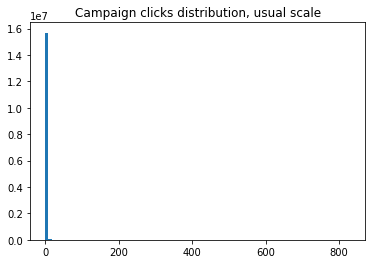

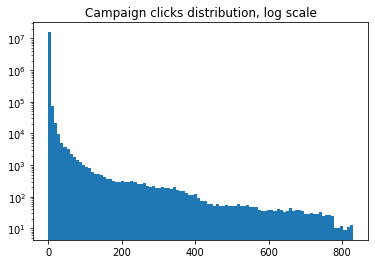

2021-09-26    3102610
2021-09-29    2420588
2021-09-27    2367303
2021-09-28    2307355
2021-10-02    2128978
2021-09-30    1851189
2021-10-01    1643448
2021-09-01          1
Name: date, dtype: int64


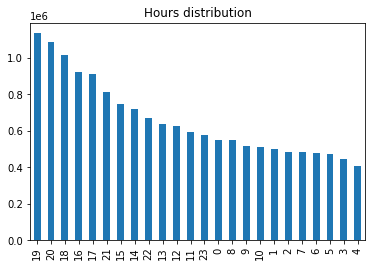

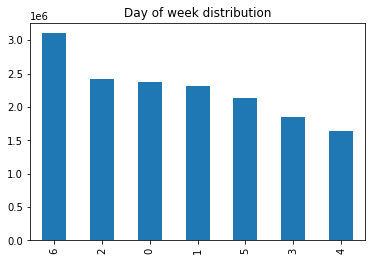

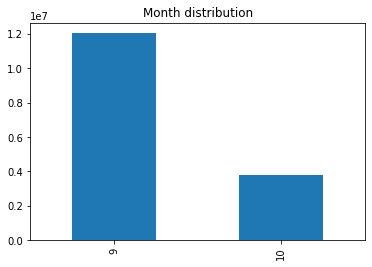

In [4]:
analysis(data)

**Небольшие выводы по анализу**

1. нет NAs
2. Все баннеры и зоны показа последнего дня имеются в данных предыдущих дней, так что чисто в теории их можно использовать (хотя кол-во переменных, закодированных с помощью one-hot-encoding) будет возможно слишком большим)
3. Из колонки date_time, кажется, есть смысл взять лишь час и, возможно, день недели. В данных по факту представлена лишь одна неделя.
4. Колонка impressions полностью состоит из единиц, что логично, поэтому удалим ее.
5. Колонка campaign_clicks может быть полезной, но возможно лучше использовать ее логарифм, так как существует слишком много маленьких значений и лишь единицы больших, из-за чего она очень перекошена.

In [5]:
from scipy.sparse import hstack

def feature_engineering(data: pd.DataFrame):
    data = data.copy()
    # создаем колонки час и день недели
    data['date_time'] = pd.to_datetime(data['date_time'])
    data['day_of_week'] = data['date_time'].dt.dayofweek
    data['hour'] = data['date_time'].dt.hour
    data['date'] = data['date_time'].dt.date
    # логарифмируем колонку campaign_clicks
    data['campaign_clicks'] = np.log(data['campaign_clicks']+0.001)
    # эти колонки будем использовать для обучения (кроме date и clicks)
    data = data[['day_of_week', 'hour', 'os_id', 'country_id', 'zone_id', 'banner_id', 'campaign_clicks', 'date', 'clicks']]
    # делим на train и test
    train = data[data['date'] < pd.to_datetime('2021-10-02')]
    test = data[data['date'] == pd.to_datetime('2021-10-02')]
    # лейблы
    y_train = np.array(train['clicks'])
    y_test = np.array(test['clicks'])
    train = train.drop(['date', "clicks"], axis=1)
    test = test.drop(['date', "clicks"], axis=1)
    # закодируем все фичи с помощью one-hot-encoding, кроме campaign_clicks
    enc = OneHotEncoder(drop='first', handle_unknown='ignore', sparse=True)
    X_train = enc.fit_transform(train.drop(['campaign_clicks'], axis=1))
    X_test = enc.transform(test.drop(['campaign_clicks'], axis=1))

    X_train = hstack([X_train, np.array(train['campaign_clicks']).reshape(-1, 1)])
    X_test = hstack([X_test, np.array(test['campaign_clicks']).reshape(-1, 1)])

    return X_train, X_test, y_train, y_test

In [6]:
X_train, X_test, y_train, y_test = feature_engineering(data)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

/usr/local/lib/python3.8/dist-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [0, 4, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


(13692494, 4969) (2128978, 4969) (13692494,) (2128978,)


Итого были взяты следующие признаки: 'day_of_week', 'hour', 'os_id', 'country_id', 'zone_id', 'banner_id', 'campaign_clicks'. Все, кроме последнего, трансформируются с помощью one-hot encoding.

Буду обучать логистическую регрессию. С помощью кросс-валидации буду подбирать параметр C и вид регуляризации (l1, l2). В качестве оптимизатора используется liblinear.

In [7]:
from sklearn.linear_model import LogisticRegression

def create_model(**args):
    model = LogisticRegression(solver='liblinear',
                               random_state=10,
                               **args)
    return model

In [8]:
from sklearn.model_selection import cross_validate

def cv(X_train, y_train):
    np.random.seed(10)
    results = []
    Cs = [0.0001, 0.001, 0.01, 0.1, 1]
    l1s = ['l1', 'l2']

    for C in Cs:
        for l1 in l1s:
            print(f'C={C}, penalty={l1}')
            params = {'C': C, 'penalty': l1}
            model = create_model(**params)
            res = cross_validate(model, X_train, y_train, scoring='neg_log_loss', cv=3)
            results.append([C, l1, np.mean(res['test_score'])])

    return results

In [9]:
cv_results = cv(X_train, y_train)

C=0.0001, penalty=l1
C=0.0001, penalty=l2
C=0.001, penalty=l1
C=0.001, penalty=l2
C=0.01, penalty=l1
C=0.01, penalty=l2
C=0.1, penalty=l1
C=0.1, penalty=l2
C=1, penalty=l1
C=1, penalty=l2


Обучаем итоговую модель с подобранными параметрами (выбираем лучшие по значению отрицательного log loss), сравниваем с бейзлайном

In [10]:
cv_results = np.array(cv_results)
best_try = np.argmax(cv_results[:, 2])
C, l1 = cv_results[best_try, 0], cv_results[best_try, 1]
print(f'Best params: C={C}, penalty={l1}')
params = {'C': float(C), 'penalty': l1}
model = create_model(**params)
model.fit(X_train, y_train)

Best params: C=1, penalty=l1


LogisticRegression(penalty='l1', random_state=10, solver='liblinear')

In [11]:
from sklearn.metrics import log_loss, roc_auc_score

def eval_prediction(y_pred, y_test):
    loss = log_loss(y_test, y_pred)
    roc_score = roc_auc_score(y_test, y_pred)
    print(f"Log loss: {loss}, roc-auc: {roc_score}")

Результаты модели

In [12]:
preds = model.predict_proba(X_test)
eval_prediction(preds[:, 1], y_test)

Log loss: 0.13470393222089588, roc-auc: 0.7788421085354904


Бейзлайн

In [13]:
train_mean = np.mean(y_train)
preds_base = np.ones_like(y_test) * train_mean
eval_prediction(preds_base, y_test)

Log loss: 0.15486198009919555, roc-auc: 0.5


Модель превзошла безйлайн.